In [643]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as sts
matplotlib.rcParams.update({'font.size': 14})

## Part 1: Traffic jams on a circular road

In [537]:
class TrafficSimulation:
    def __init__(self, road_length=50, traffic_density=0.03, max_velocity=5, probability_slow_down=0.5):
        '''
        Initialization for single-lane traffic simulation.
        
        Parameters
        ----------
        road_length: int
            number of sites where cars can stay on the road
        traffic_density: float
            number of cars per site (< 1)
        max_velocity: bool
            maximum velocity at which cars can go 
        probability_slow_down: float
            probability that any car will randomly slow down by 1
        '''
        
        self.road_len = road_length
        self.traff_dens = traffic_density
        self.max_vel = max_velocity
        self.prob_slow = probability_slow_down
        self.fl_count = 0
        self.timestep = 0
       
        self.traff_state = self.initialize_traffic()
        
    def initialize_traffic(self):
        self.fl_count = 0
        self.timestep = 0
        traff_state = np.repeat(-1, self.road_len)
        num_cars = self.probabilistic_round(self.traff_dens * self.road_len)
        car_locs = np.random.choice(traff_state.size, num_cars, replace=False)
        traff_state[car_locs] = self.init_velocity(num_cars)

        return traff_state
    
    def run_simulation(self, num_iter=15, display=True):
        self.traff_state = self.initialize_traffic()
        
        for it in range(num_iter):
            self.update_velocities()
            if display:
                self.display() 
            self.advance_cars()
            self.timestep += 1
            
        return self.fl_count / num_iter

    def update_velocities(self):
        car_locs = np.where(self.traff_state != -1)[0]  # get car locations
        for i, car_loc in enumerate(car_locs):
            # check distance of car in front
            if len(car_locs) > 1:
                next_car = i + 1 if i + 1 < len(car_locs) else 0
                dist_to_next_car = (car_locs[next_car] - car_loc) % self.road_len   
            else:
                dist_to_next_car = self.road_len
            
            # acceleration
            if self.traff_state[car_loc] < self.max_vel and self.traff_state[car_loc] + 1 < dist_to_next_car:
                self.traff_state[car_loc] += 1
            
            # slowing
            if self.traff_state[car_loc] >= dist_to_next_car:
                self.traff_state[car_loc] = dist_to_next_car - 1
                
            # random slowing
            rand_num = random.random()
            if rand_num < self.prob_slow and self.traff_state[car_loc] > 0:
                self.traff_state[car_loc] -= 1          
    
    def advance_cars(self):
        car_locs = np.where(self.traff_state != -1)[0]  # get car locations
        for car_loc in car_locs:
            cur_vel = self.traff_state[car_loc]
            next_loc = (car_loc + cur_vel * 1) % self.road_len  # check the boundary condition
            self.update_flow(car_loc, next_loc)
            self.traff_state[car_loc] = -1
            self.traff_state[next_loc] = cur_vel
            

    def update_flow(self, car_loc, next_loc):
        bound_passed = next_loc < car_loc
        
        if bound_passed:
            self.fl_count += 1
            
    def reset_flow(self):
        self.fl_count = 0
        
    def get_cur_flow(self):
        if self.timestep == 0:
            cur_flow = 0
        else:
            cur_flow = self.fl_count / self.timestep
            
        return cur_flow
        
    def display(self):
        cur_dens = np.sum(self.traff_state != -1) / self.traff_state.size
        cur_flow = self.get_cur_flow()
        print(''.join('·' if x == -1 else str(x) for x in self.traff_state) + '\tdensity=' + str(cur_dens) + ' flow=' + str(np.round(cur_flow, 2)))
        print('\n')  # create space between consecutive states of multi-lane road
        
    @staticmethod
    def probabilistic_round(num):
        return int(math.floor(num + random.random()))
    
    def init_velocity(self, num_cars):
        rand_vels = np.random.randint(self.max_vel, size=num_cars)
        return rand_vels
    
    def __getitem__(self, index):
        return self.traff_state[index]
        
    def __setitem__(self, index, value):  
        self.traff_state[index] = value

### State visualization

In [639]:
traff_sim = TrafficSimulation(traffic_density=0.3)
traff_sim.run_simulation(num_iter=10)

····02··00······01·1········2···01·0·1··0···2··2··	density=0.3 flow=0


····1··001······0·1·2·········0·1·01··0·0·····2··2	density=0.3 flow=0.0


·3···0·00·2·····0··2··2·······0··01·0·1·0·······2·	density=0.3 flow=0.5


2···01·00···3···0····1··2·····0··0·01··00·········	density=0.3 flow=0.67


··0·1·001······00·····1···2···0··0·0·1·01·········	density=0.3 flow=0.5


··0··001·1·····00······1····0·0··1·1··01·2········	density=0.3 flow=0.4


··1··01·1·1····01·······1···1·0···0·1·1·2··3······	density=0.3 flow=0.33


···1·0·0·0·2···0·2·······1···01···1··0·2··2···3···	density=0.3 flow=0.29


····00·1·0···0·1···2······2··1·1···1·0···1··2····4	density=0.3 flow=0.25


···000··01···1··1····3······0·1·2···01····1···2···	density=0.3 flow=0.33




0.3

### Flow visualization

In [552]:
def generate_flow_for_densities(num_sim=40, num_iter=400):
    traff_dens_linspace = np.linspace(0, 0.8, 50)
    flow_storage = []

    for traff_dens in traff_dens_linspace:
        traff_sim = TrafficSimulation(traffic_density=traff_dens)
        flow_storage.append([traff_sim.run_simulation(num_iter=num_iter, display=False) for i in range(num_sim)])
        
    return np.array(flow_storage), traff_dens_linspace

def plot_flow_over_densities(flow_store, traff_dens_linspace):
    mean_flows = flow_store.mean(axis=1)

    plt.figure(figsize=(16, 6), dpi=330)
    plt.plot(traff_dens_linspace, mean_flows, linewidth=2, color='red')
    for j in range(flow_store.shape[1]):
        plt.scatter(traff_dens_linspace, flow_store[:, j], color='black', alpha=0.05)
        
    plt.ylabel('Flow per lane [cars / timestep]')
    plt.xlabel('Average traffic density [cars / site]')
    plt.show()

In [545]:
flow_store, traff_dens_linspace = generate_flow_for_densities()

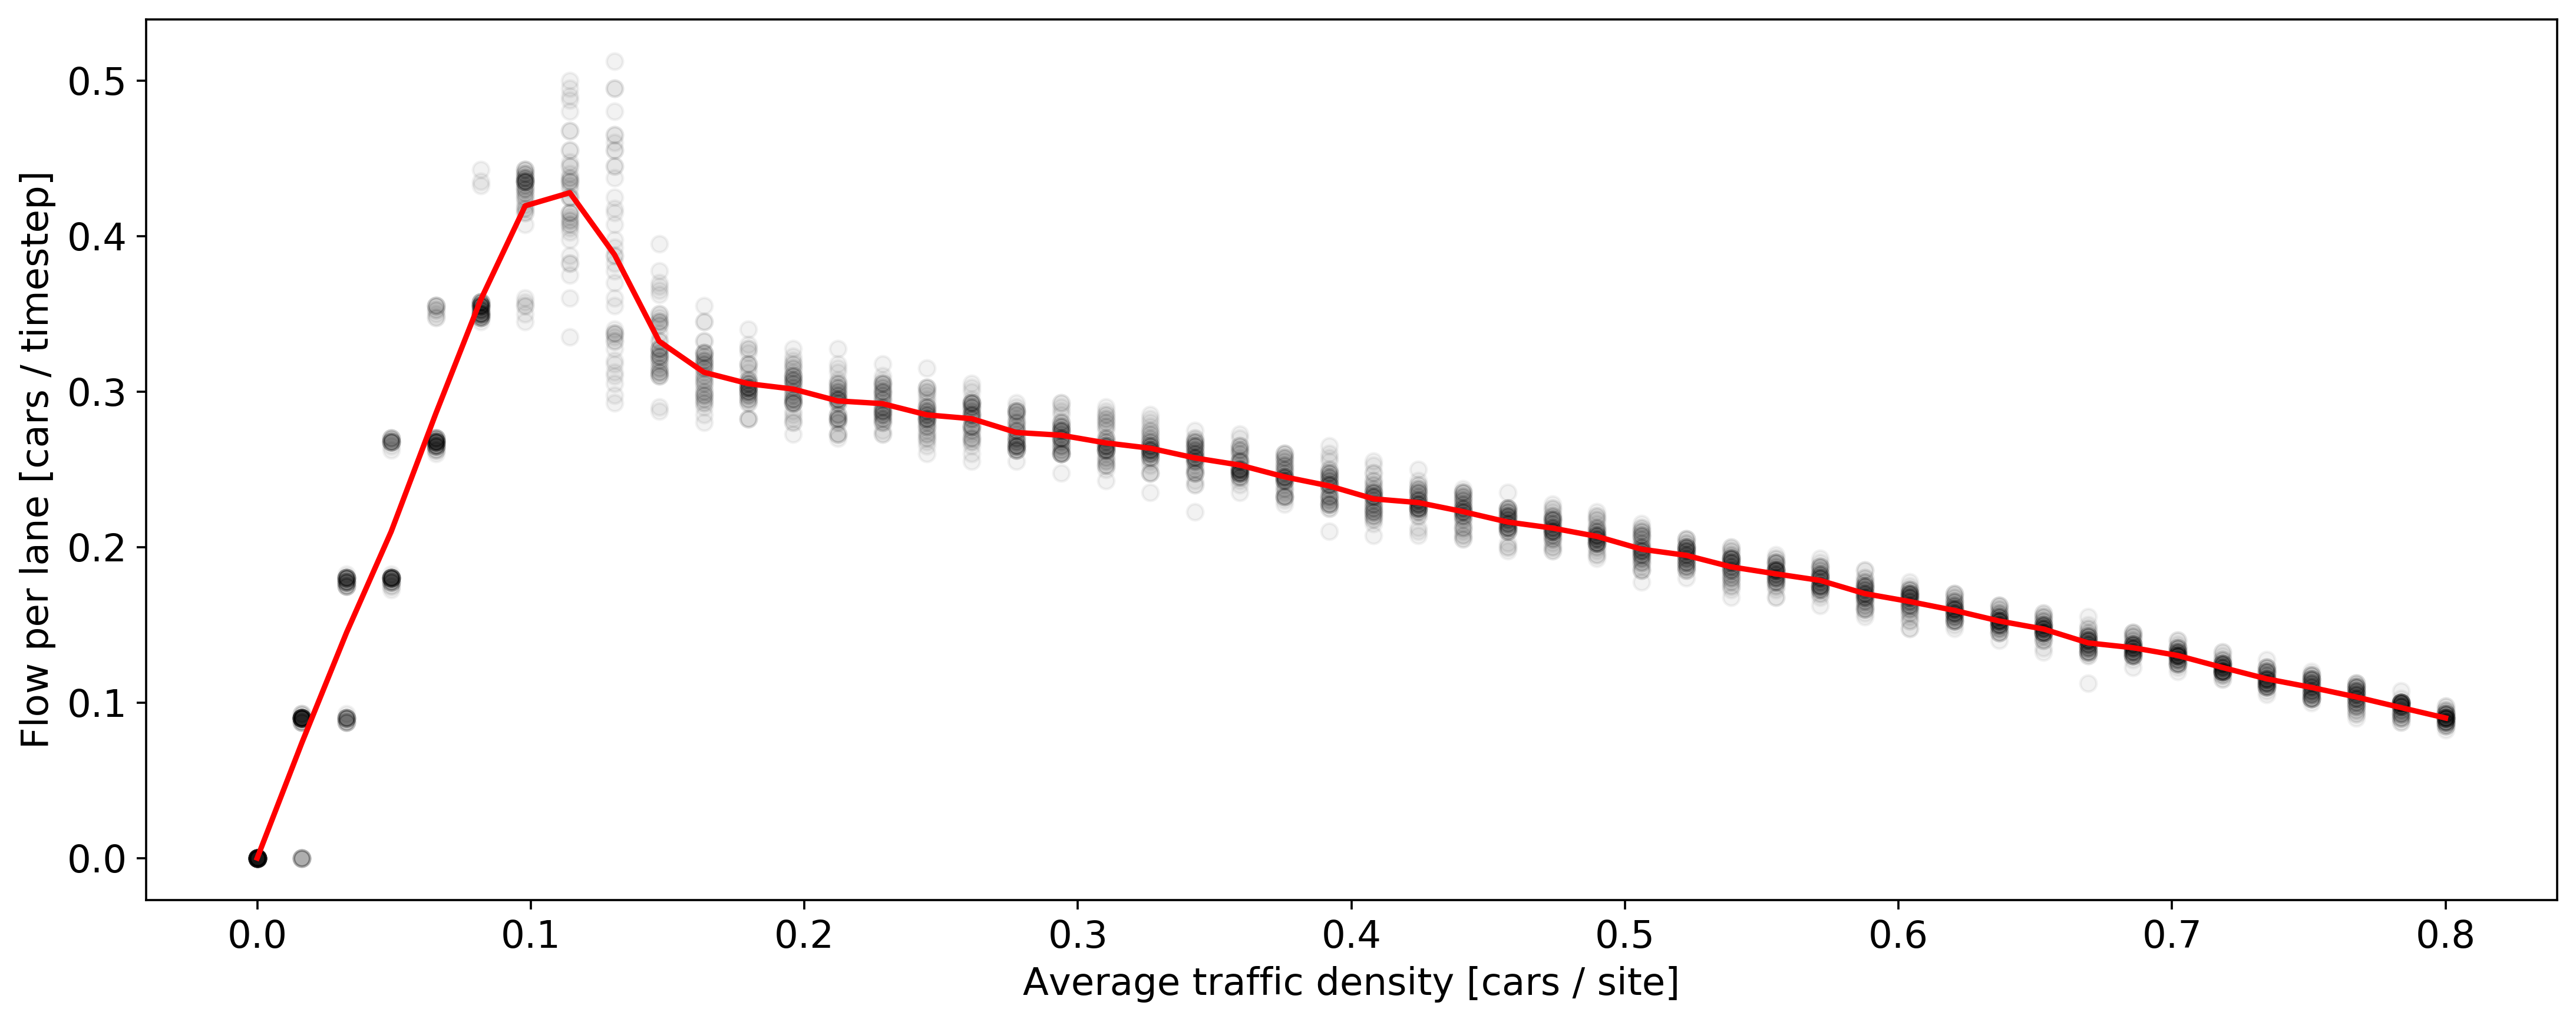

In [644]:
plot_flow_over_densities(flow_store, traff_dens_linspace)

## Part 2: Multi-lane highways

In [658]:
class TrafficSimulationMultilane:
    def __init__(
        self, num_lanes=2, probability_switch_lane=0.2, uniform_init_distribution=False,  # multi-lane properties
        road_length=50, traffic_density=0.03, max_velocity=5, probability_slow_down=0.5  # single-lane properties
    ):  
        '''
        Initialization for multi-lane traffic simulation.
        
        Parameters
        ----------
        num_lanes: int
            number of lanes in the multi-lane traffic system
        probability_switch_lane: float
            probability that a car will swithc lanes, given no cars in back or front on other lane
        uniform_init_distribution: bool
            initialize roads with the same density
        TrafficSimulation's initialization parameters
            
        '''
        
        self.num_lanes = num_lanes
        self.prob_switch_lane = probability_switch_lane
        self.uniform_distr = uniform_init_distribution
        
        self.road_len = road_length
        self.traff_dens = traffic_density
        self.max_vel = max_velocity
        self.prob_slow = probability_slow_down
        self.tot_fl_count = 0
        
        # initialize multiple lanes randomly given initial traffic density
        self.roads = self.initialize_roads(self.uniform_distr)
        
    def initialize_roads(self, uniform=False):
        '''
        Initialize cars on road lanes.
        
        Parameters
        ----------
        uniform: bool
            indicates whether all roads should have the same initial traffic density
        
        Returns
        ----------
        roads: list of TrafficSimulation objects
            roads with initialized traffic
        '''
        
        roads = []
        if uniform:
            for _ in range(num_lanes):
                roads.append(
                    TrafficSimulation(
                        road_length=self.road_len,
                        traffic_density=self.traff_dens,
                        max_velocity=self.max_vel,
                        probability_slow_down=self.prob_slow))
        else:
            total_cells = self.num_lanes * self.road_len
            flattened_road = np.repeat(-1, total_cells)
            num_cars = TrafficSimulation.probabilistic_round(self.traff_dens * total_cells)
            car_locs = np.random.choice(flattened_road.size, num_cars, replace=False)
            flattened_road[car_locs] = 0  # indicate where cars would be

            # resize the flattened road into lanes and initialize with respective densities
            lanes = flattened_road.reshape(self.num_lanes, self.road_len)
            for lane in lanes:
                num_cars_in_lane = np.sum(lane == 0)
                lane_dens = num_cars_in_lane / self.road_len
                roads.append(
                    TrafficSimulation(
                        road_length=self.road_len,
                        traffic_density=lane_dens,
                        max_velocity=self.max_vel,
                        probability_slow_down=self.prob_slow))
                
        return roads
    
    def run_simulation(self, num_iter=10, display=True):
        self.traff_state = self.initialize_roads()
        self.reset_tot_flow()
        
        for it in range(num_iter):
            if display:
                self.display()
            self.update()
            
        for road in self.roads:
            self.tot_fl_count += road.fl_count
        
        return self.tot_fl_count / num_iter / self.num_lanes  # average flow in a lane
    
    def update(self):        
        # update lanes
        for i, road in enumerate(self.roads):
            car_locs = np.where(road.traff_state != -1)[0]
            for cell_id, car_loc in enumerate(car_locs):
                switches = self.get_switch_directions(i, car_loc)
                
                if len(switches) > 0:  # there are available lane switches:
                    switch_dir = np.random.choice(switches, 1)[0]
                    if random.random() < self.prob_switch_lane:
                        self.roads[i + switch_dir][car_loc] = self.roads[i][car_loc]
                        self.roads[i][car_loc] = -1
        
        # update velocities
        for road in self.roads:
            road.update_velocities()
        
        # advance cars
        for road in self.roads:
            road.timestep += 1
            road.advance_cars()
            
    def get_switch_directions(self, road_idx, car_loc):
        '''
        Determine lanes that a car can switch to given its location.
        
        Parameters
        ----------
        road_idx: int
            index of the road lane on which a car is located
        car_loc: int
            site where a car is located
        
        Returns
        ----------
        switches: list
            list consisting of either -1, 1, or both to indicate available switch directions
        '''
        
        switch_up, switch_down = False, False
        if road_idx > 0:
            switch_up = self.check_lane_free(road_idx, road_idx - 1, car_loc)
        if road_idx < self.num_lanes - 1:
            switch_down = self.check_lane_free(road_idx, road_idx + 1, car_loc)

        switches = []  # get available lane switch directions
        if switch_up:
            switches.append(-1)  # up
        if switch_down:
            switches.append(1)  # down
            
        return switches
            
    def check_lane_free(self, road_from, road_to, insert_pos):
        vel = self.roads[road_from][insert_pos]
        # using distance instead of gap to calculate freeness of other lane
        lookback_idx = (insert_pos - 5) % self.road_len  
        lookahead_idx = (insert_pos + vel + 1) % self.road_len 
        # print(lookback_idx, lookahead_idx)

        if lookback_idx < lookahead_idx:  # checking if we are crossing the periodic boundary
            lane_free = np.all(self.roads[road_to][lookback_idx:lookahead_idx] == -1)
        else:  # we are crossing the periodic boundary
            lane_free = np.all(self.roads[road_to][:lookahead_idx] == -1) and\
                        np.all(self.roads[road_to][lookback_idx:] == -1) 
        
        return (True if lane_free else False)
    
    def reset_tot_flow(self):
        self.tot_fl_count = 0
        for road in self.roads:
            road.reset_flow()
    
    def display(self):
        avg_flow = 0
        for i, road in enumerate(self.roads):
            cur_dens = np.sum(road.traff_state != -1) / road.traff_state.size
            cur_flow = road.get_cur_flow()
            avg_flow += np.round(cur_flow / self.num_lanes, 2)
            last_print = ' avg_flow={}'.format(avg_flow) if i == self.num_lanes - 1 else ''
            
            print(''.join('·' if x == -1 else str(x) for x in road.traff_state) + '\tdensity=' + str(cur_dens) + ' flow=' + str(np.round(cur_flow, 2)) + last_print)
        print('\n')  # create space between consecutive states of multi-lane road

### State visualization

In [695]:
multlane_sim = TrafficSimulationMultilane(num_lanes=2, traffic_density=0.04, probability_switch_lane=0.5)

In [696]:
multlane_sim.run_simulation()

················································2·	density=0.02 flow=0
1·····3·························0·················	density=0.06 flow=0 avg_flow=0.0


2·······························0·················	density=0.04 flow=1.0
·1········4·······································	density=0.04 flow=0.0 avg_flow=0.5


··2···········4···································	density=0.04 flow=0.5
··1······························1················	density=0.04 flow=0.0 avg_flow=0.25


····2·············4················2··············	density=0.06 flow=0.33
···1··············································	density=0.02 flow=0.0 avg_flow=0.17


·······3··············4···············3···········	density=0.06 flow=0.25
·····2············································	density=0.02 flow=0.0 avg_flow=0.12


···········4··············4···············4·······	density=0.06 flow=0.2
·······2··········································	density=0.02 flow=0.0 avg_flow=0.1


···············4···············5·

0.1

### Flow visualization

In [556]:
def generate_flow_for_densities_multilane(num_lanes=2, probability_switch_lane=0.5, num_sim=40, num_iter=400):
    traff_dens_linspace = np.linspace(0, 0.8, 50)
    flow_storage = []

    for traff_dens in traff_dens_linspace:
        traff_sim = TrafficSimulationMultilane(
            num_lanes=num_lanes,
            probability_switch_lane=probability_switch_lane,
            traffic_density=traff_dens)
        flow_storage.append([traff_sim.run_simulation(num_iter=num_iter, display=False) for i in range(num_sim)])
        
    return np.array(flow_storage), traff_dens_linspace

In [558]:
flow_store_2lanes, traff_dens_linspace = generate_flow_for_densities_multilane()

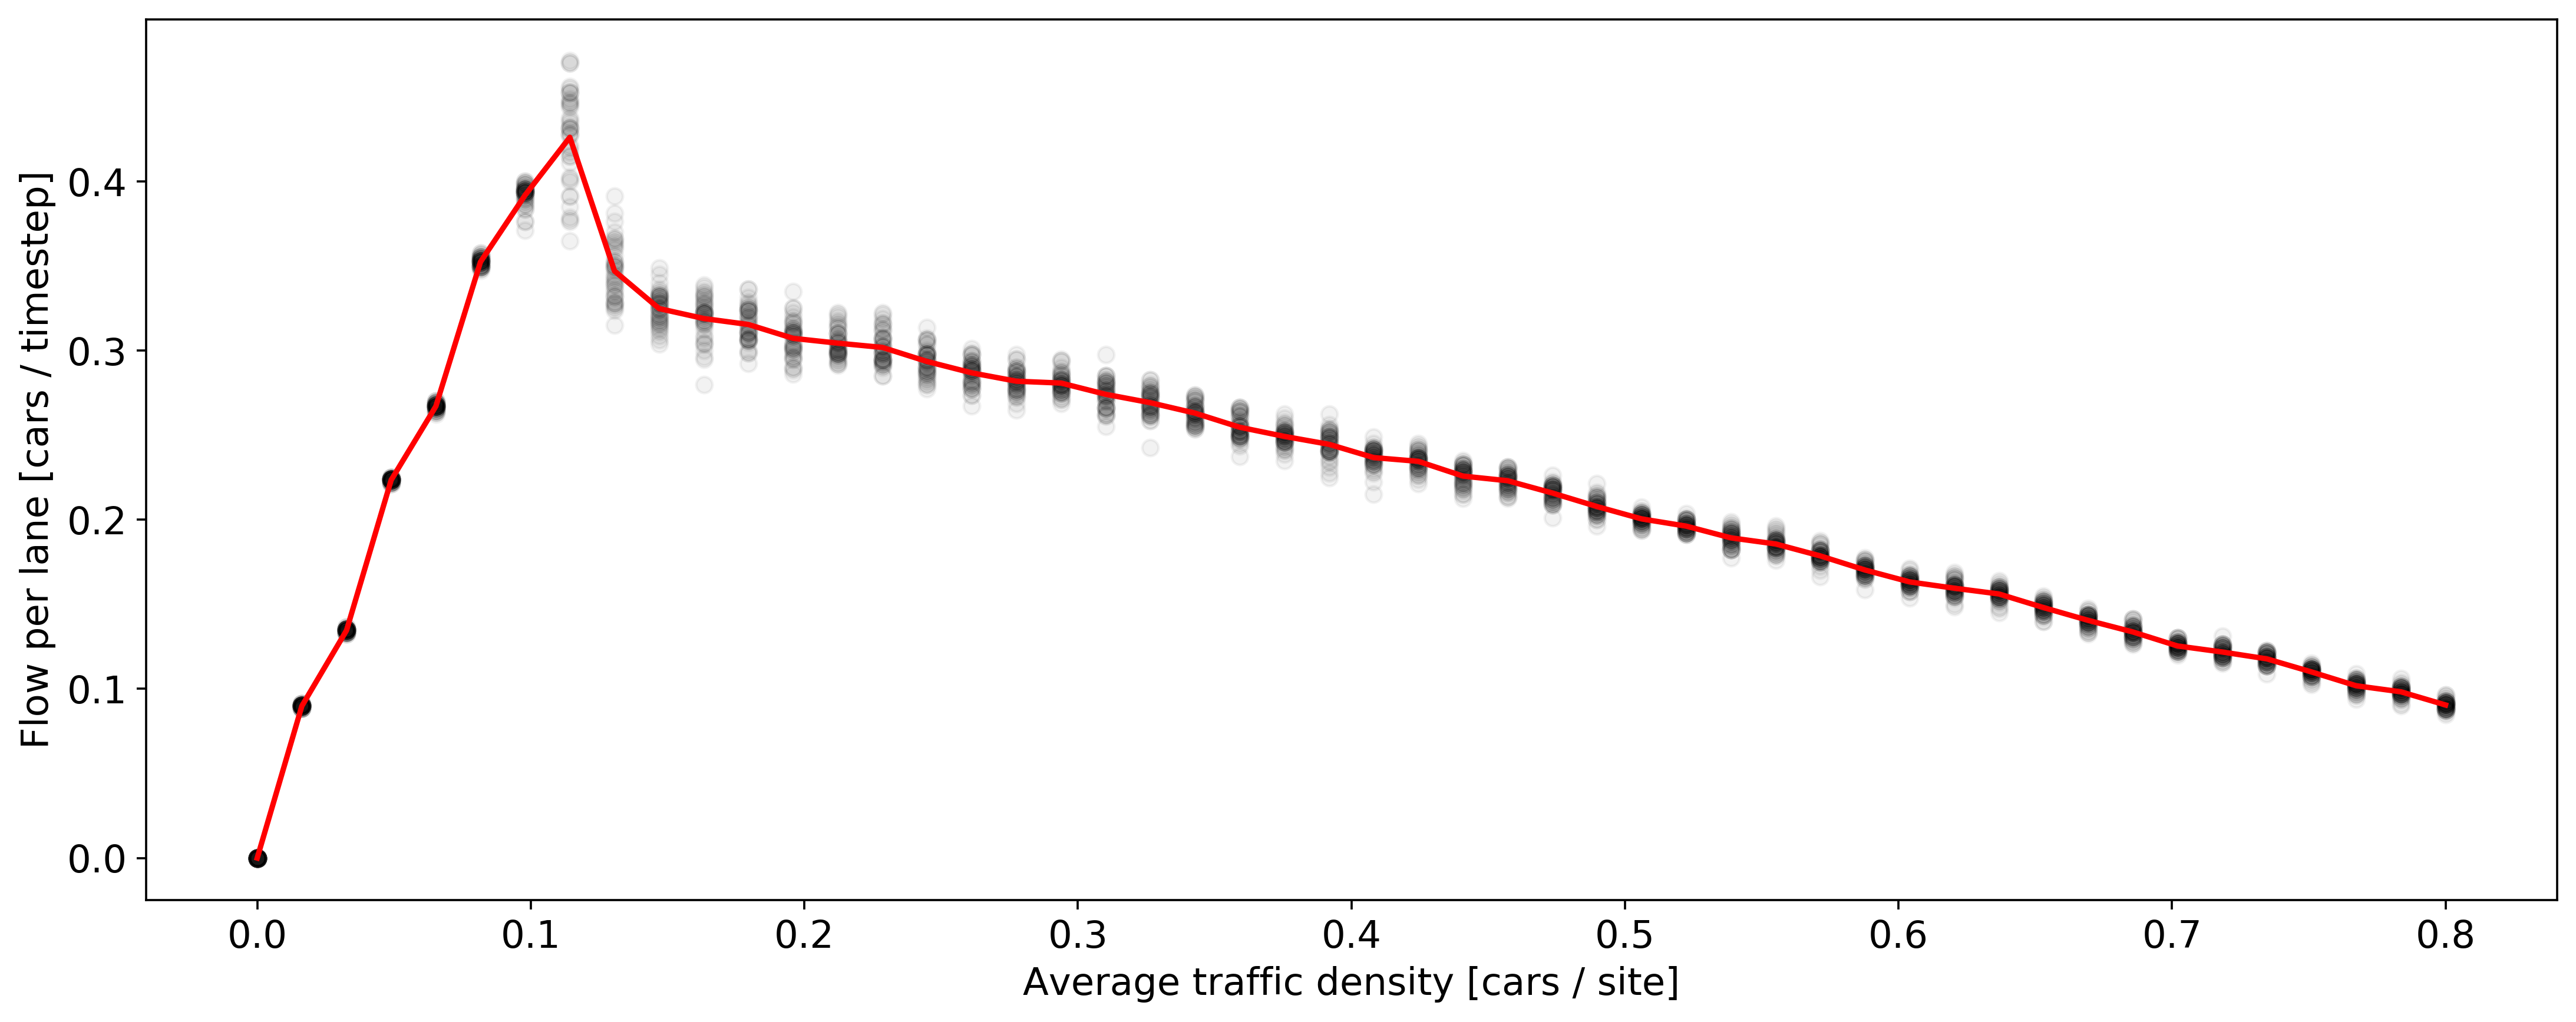

In [647]:
plot_flow_over_densities(flow_store_2lanes, traff_dens_linspace)

In [560]:
flow_store_3lanes, traff_dens_linspace = generate_flow_for_densities_multilane(num_lanes=3)

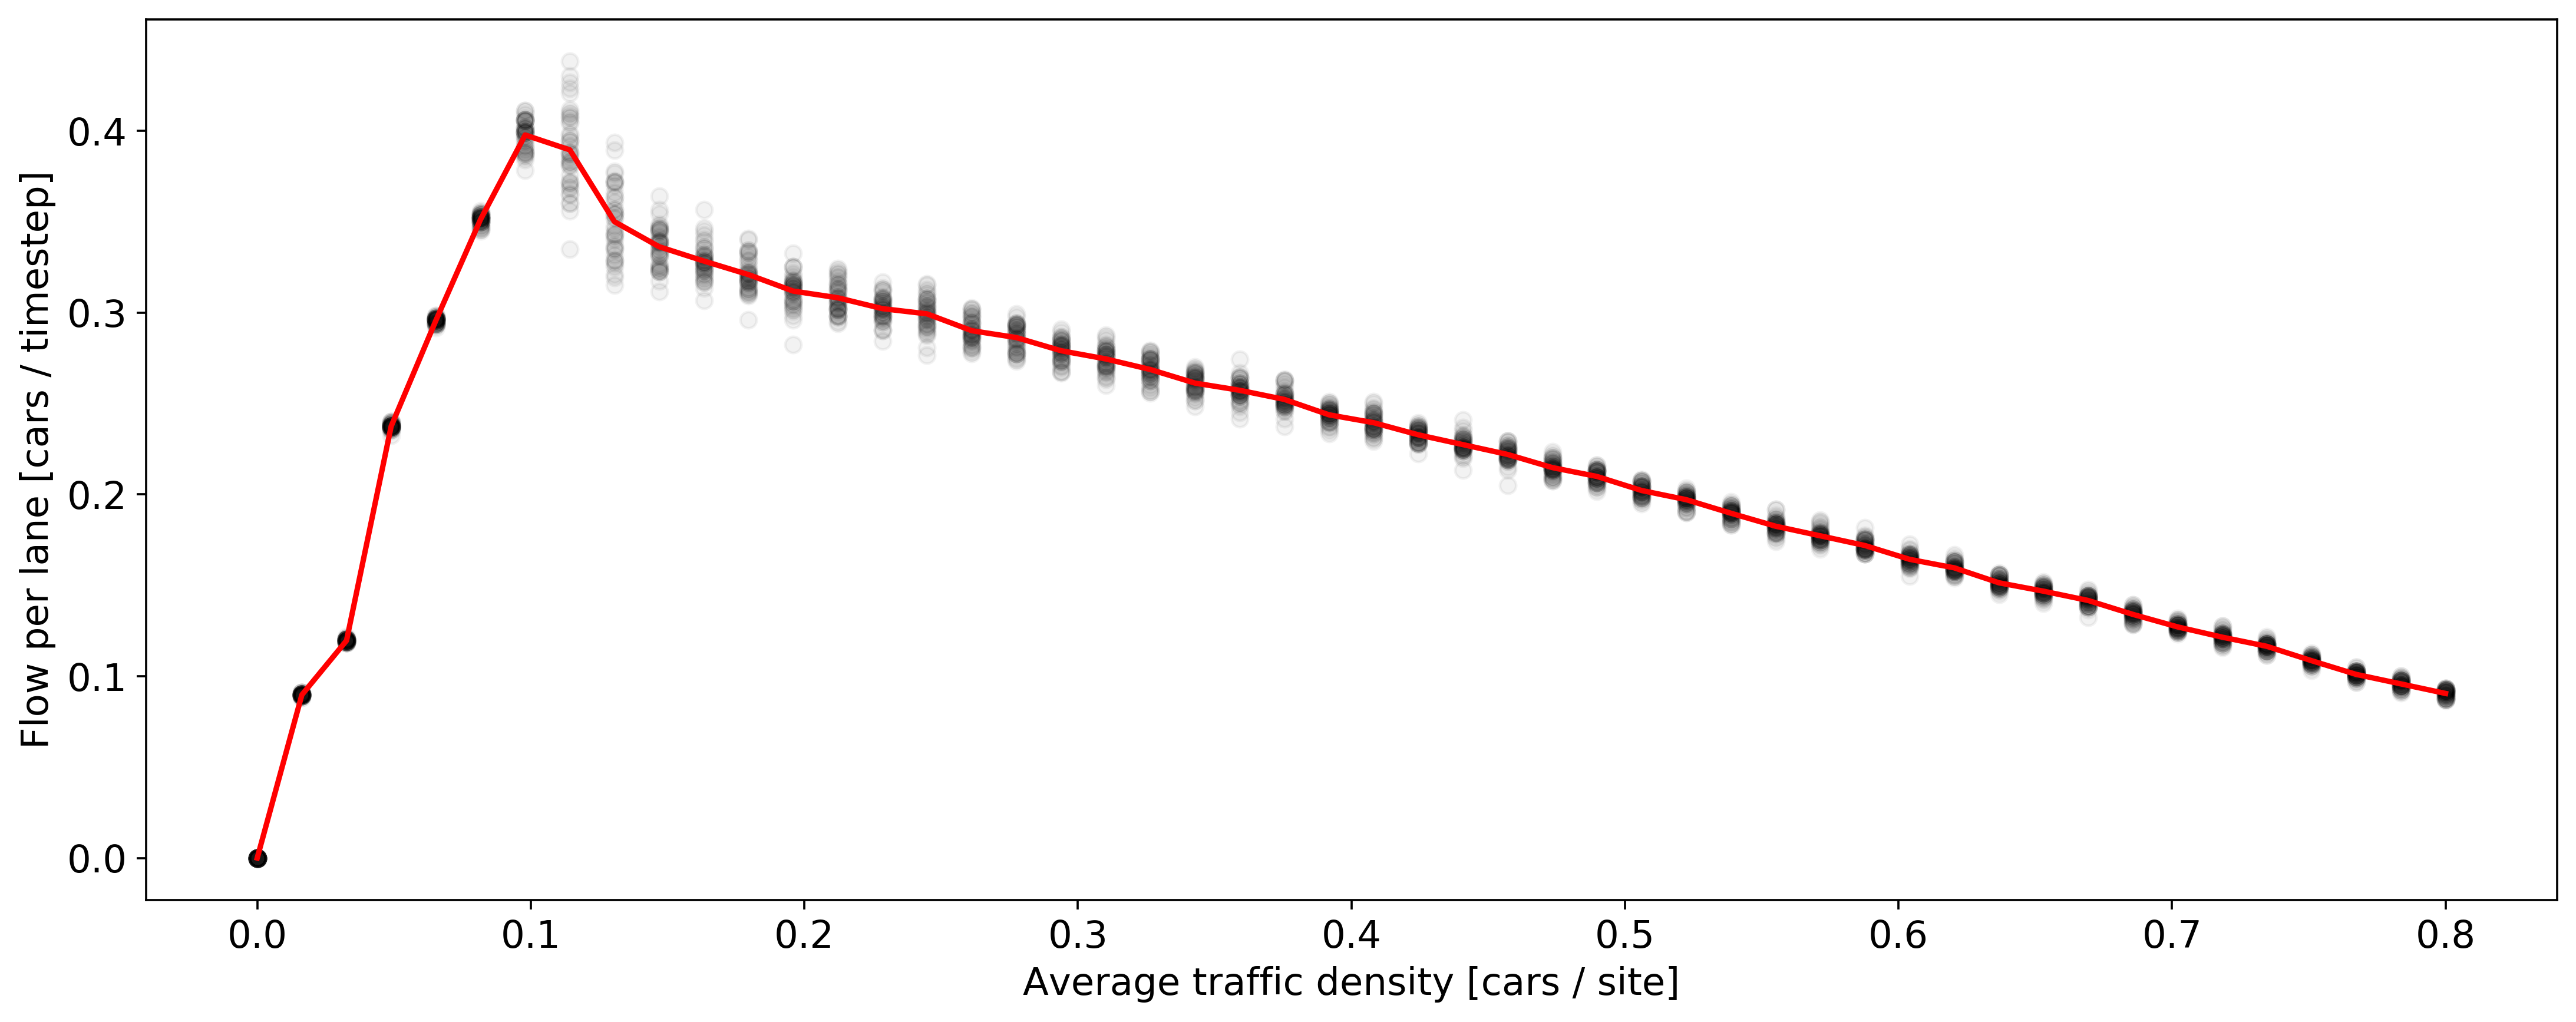

In [648]:
plot_flow_over_densities(flow_store_3lanes, traff_dens_linspace)

## Comparison

In [597]:
def get_conf_ints(flow_data):
    mean_flows = flow_data.mean(axis=1)
    conf_int = np.percentile(flow_data, [5, 95], axis=1)
    
    return mean_flows, conf_int

In [604]:
conf_int_95_1lane = get_conf_ints(flow_store)
conf_int_95_2lane = get_conf_ints(flow_store_2lanes)
conf_int_95_3lane = get_conf_ints(flow_store_3lanes)

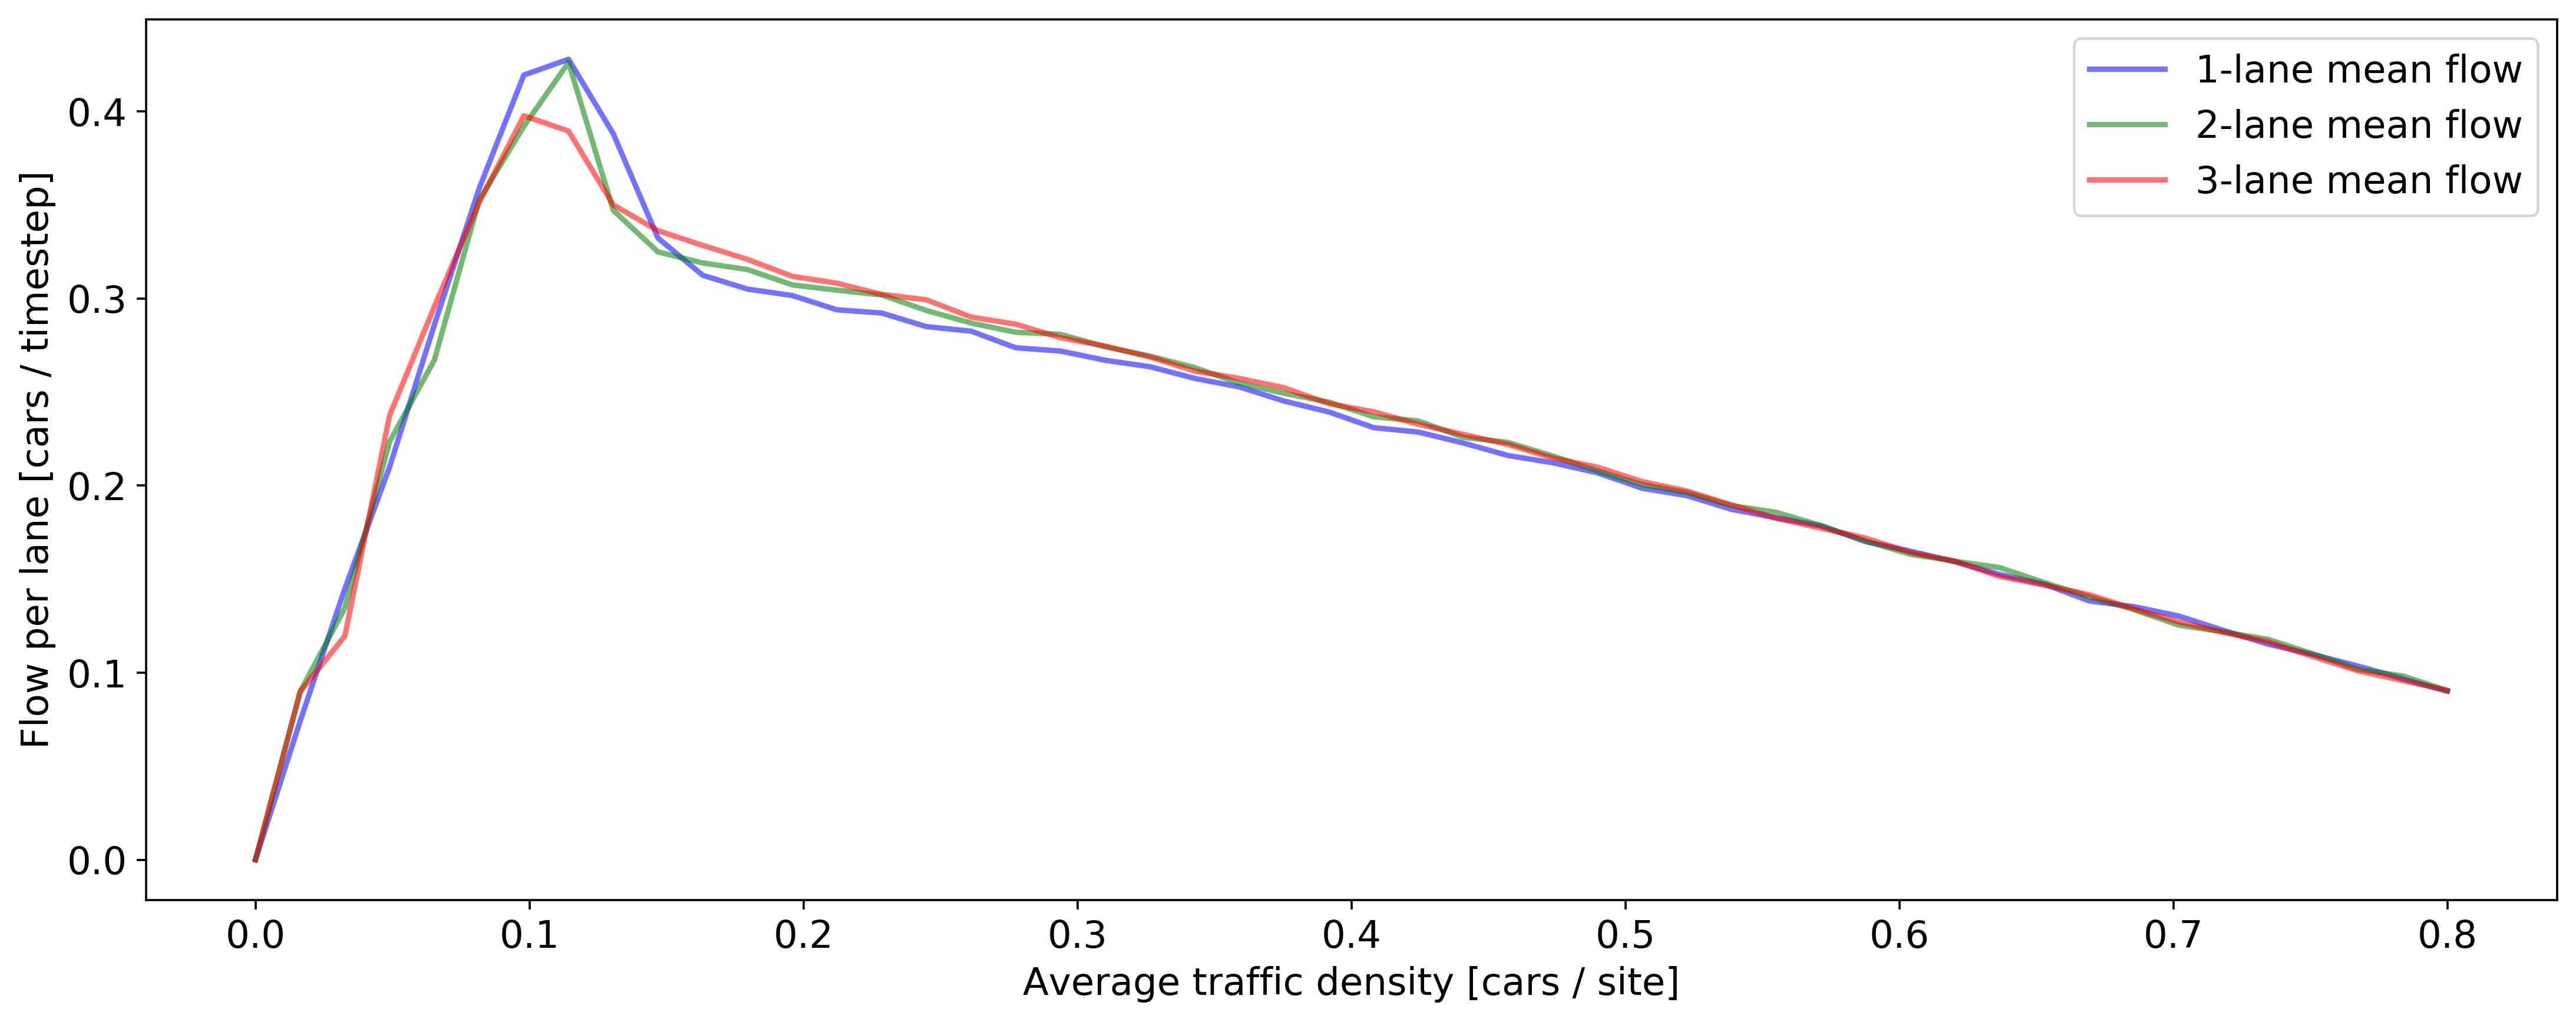

In [651]:
plt.figure(figsize=(16, 6), dpi=330)
plt.plot(traff_dens_linspace, conf_int_95_1lane[0], linewidth=2, alpha=0.55, color='blue', label='1-lane mean flow')
plt.plot(traff_dens_linspace, conf_int_95_2lane[0], linewidth=2, alpha=0.55, color='green', label='2-lane mean flow')
plt.plot(traff_dens_linspace, conf_int_95_3lane[0], linewidth=2, alpha=0.55, color='red', label='3-lane mean flow')

plt.ylabel('Flow per lane [cars / timestep]')
plt.xlabel('Average traffic density [cars / site]')
plt.legend()

plt.show()

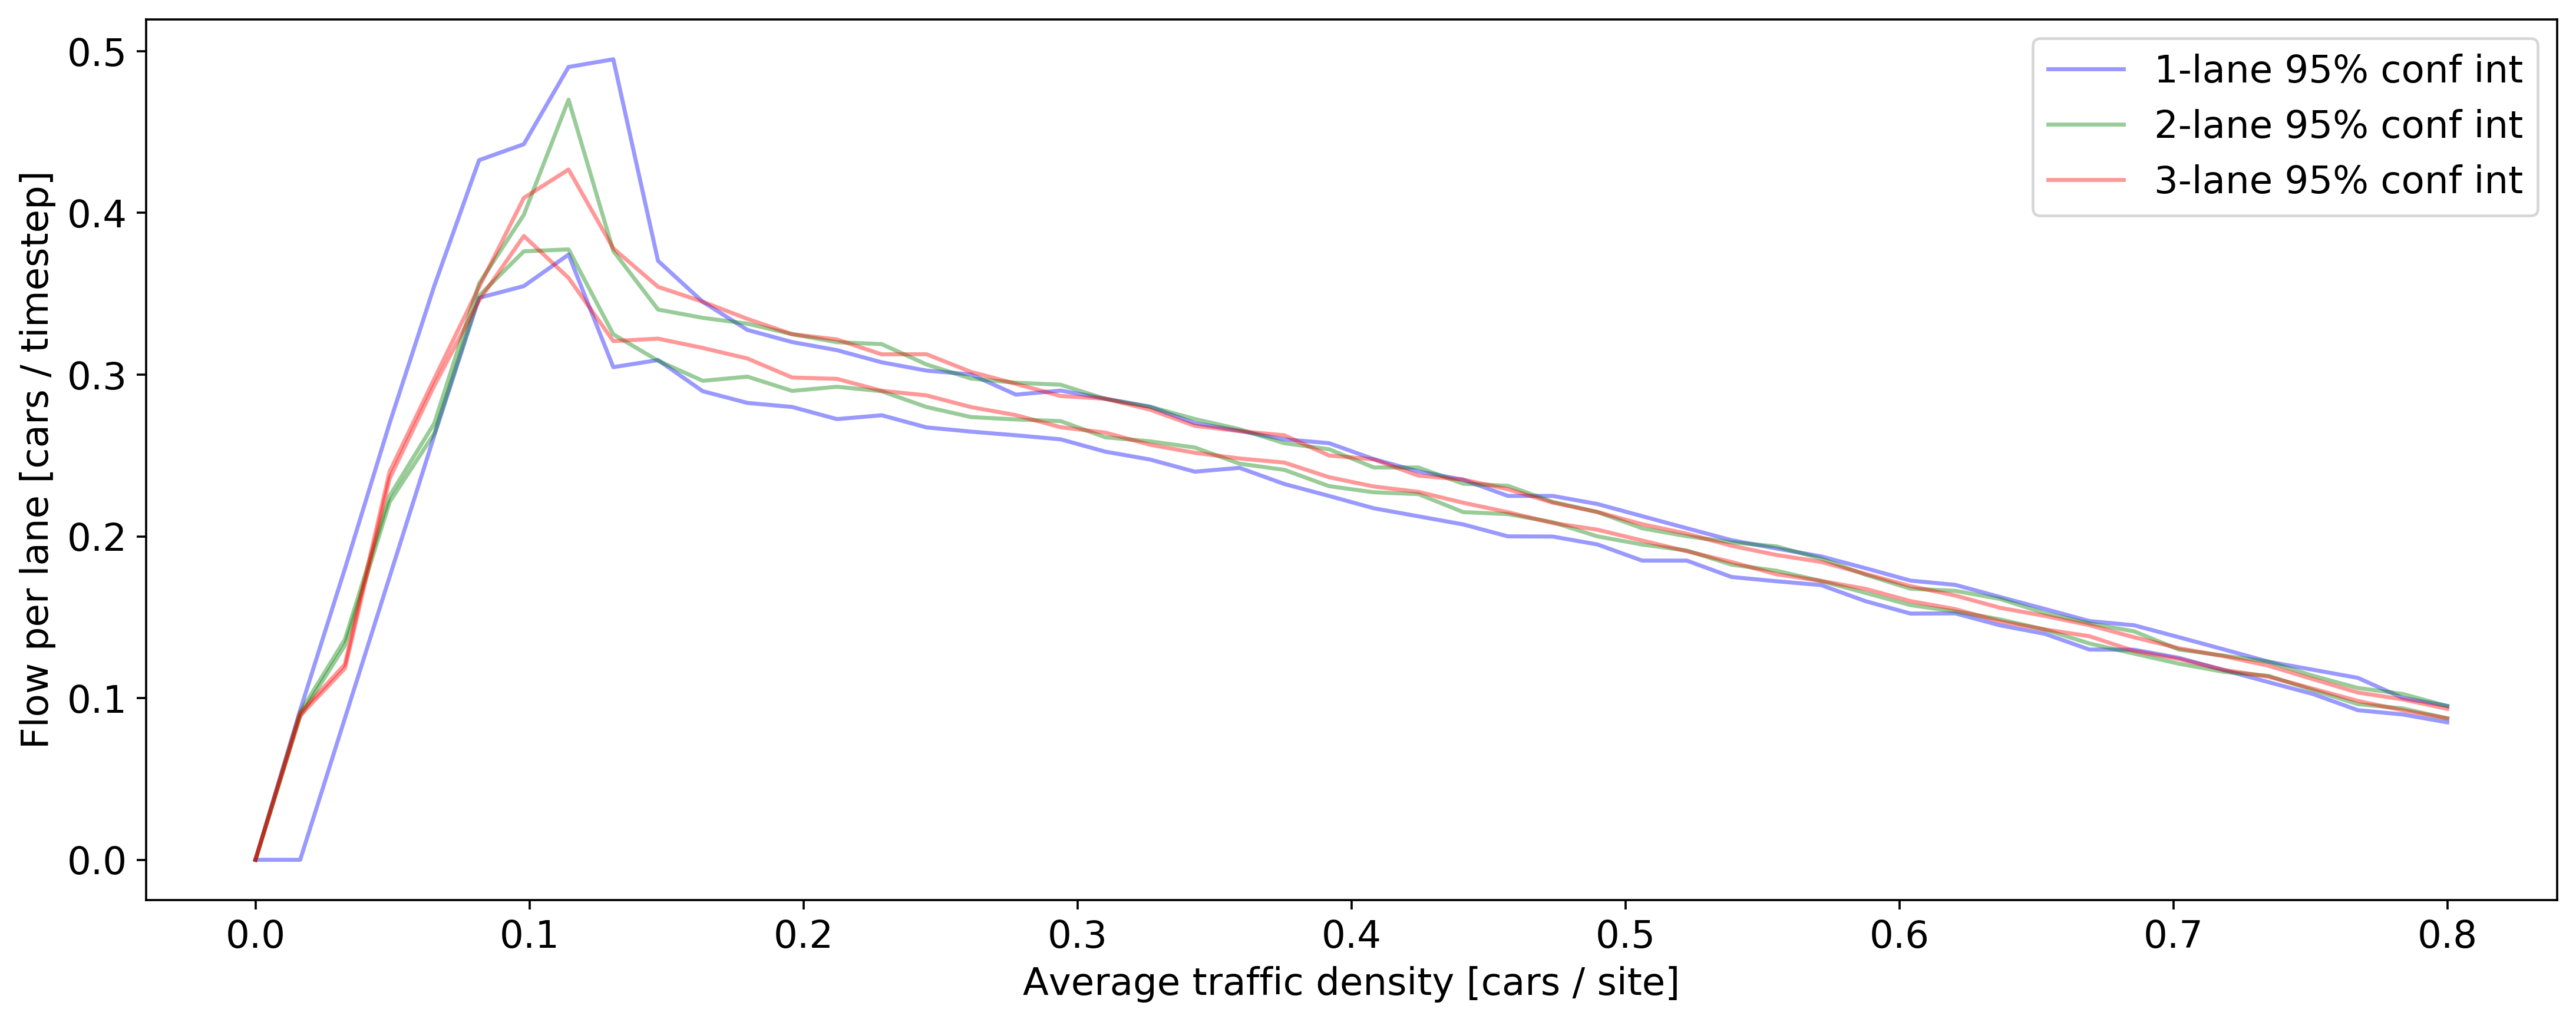

In [650]:
plt.figure(figsize=(16, 6), dpi=330)
plt.plot(traff_dens_linspace, conf_int_95_1lane[1][0], alpha=0.4, color='blue', label='1-lane 95% conf int')
plt.plot(traff_dens_linspace, conf_int_95_1lane[1][1], alpha=0.4, color='blue')

plt.plot(traff_dens_linspace, conf_int_95_2lane[1][0], alpha=0.4, color='green', label='2-lane 95% conf int')
plt.plot(traff_dens_linspace, conf_int_95_2lane[1][1], alpha=0.4, color='green')

plt.plot(traff_dens_linspace, conf_int_95_3lane[1][0], alpha=0.4, color='red', label='3-lane 95% conf int')
plt.plot(traff_dens_linspace, conf_int_95_3lane[1][1], alpha=0.4, color='red')

plt.ylabel('Flow per lane [cars / timestep]')
plt.xlabel('Average traffic density [cars / site]')

plt.legend()
plt.show()